In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/qyang/data/healthcare/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/qyang/data/healthcare/healthcare_dataset.csv


In [2]:
# 1. Load Data
# ---------------------------------------------------------
df = pd.read_csv('/home/qyang/data/healthcare/healthcare_dataset.csv')

In [6]:
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib
import boto3
import matplotlib.pyplot as plt
import seaborn as sns

# Adjust display
pd.set_option('display.max_columns', 120)

print("Loaded shape:", df.shape)
display(df.head())


Loaded shape: (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [7]:
# Cell 2: compute LOS and create binary label 'prolonged_stay'
# Parse date columns
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'], errors='coerce')
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'], errors='coerce')

# Keep only rows with both dates (completed stays)
df = df.dropna(subset=['Date of Admission', 'Discharge Date']).copy()
df['LOS_days'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# Some LOS may be negative or zero due to bad data — filter or clip
df = df[df['LOS_days'] >= 0]

# Choose threshold for 'prolonged' — e.g., >= 7 days
THRESHOLD = 7
df['prolonged_stay'] = (df['LOS_days'] >= THRESHOLD).astype(int)

print("After filtering, shape:", df.shape)
print("Prolonged stay distribution:\n", df['prolonged_stay'].value_counts(normalize=True))
display(df[['Date of Admission','Discharge Date','LOS_days','prolonged_stay']].head())



After filtering, shape: (55500, 17)
Prolonged stay distribution:
 prolonged_stay
1    0.8
0    0.2
Name: proportion, dtype: float64


,Date of Admission,Discharge Date,LOS_days,prolonged_stay
0,2024-01-31,2024-02-02,2,0
1,2019-08-20,2019-08-26,6,0
2,2022-09-22,2022-10-07,15,1
3,2020-11-18,2020-12-18,30,1
4,2022-09-19,2022-10-09,20,1


In [8]:
# Cell 3: select features available at admission time
# Remove identifying fields (Name, Room Number) and future info
drop_cols = ['Name', 'Room Number', 'Discharge Date']  # drop name and room
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# Candidate features (modify as needed)
features = [
    'Age', 'Gender', 'Blood Type', 'Medical Condition', 'Doctor',
    'Hospital', 'Insurance Provider', 'Billing Amount', 'Admission Type',
    'Medication', 'Test Results'
]
# Keep only features that exist in dataframe
features = [f for f in features if f in df.columns]
# Target
target = 'prolonged_stay'

# Quick missing value overview for chosen features
print("Feature missingness:")
print(df[features].isna().sum())

# Option: simple imputation:
# - Numeric: fillna with median for Billing Amount
# - Categorical: fillna with 'Unknown' (so encoder treats it as category)
if 'Billing Amount' in features:
    df['Billing Amount'] = df['Billing Amount'].fillna(df['Billing Amount'].median())

for f in features:
    if df[f].dtype == object:
        df[f] = df[f].fillna('Unknown')

# Now check again
display(df[features].head())


Feature missingness:
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Admission Type        0
Medication            0
Test Results          0
dtype: int64


,Age,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results
0,30,Male,B-,Cancer,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,Urgent,Paracetamol,Normal
1,62,Male,A+,Obesity,Samantha Davies,Kim Inc,Medicare,33643.327287,Emergency,Ibuprofen,Inconclusive
2,76,Female,A-,Obesity,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,Emergency,Aspirin,Normal
3,28,Female,O+,Diabetes,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,Elective,Ibuprofen,Abnormal
4,43,Female,AB+,Cancer,Kathleen Hanna,White-White,Aetna,14238.317814,Urgent,Penicillin,Abnormal


In [9]:
# Cell 4: train/test split (stratify by target to keep class balance)
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:", y_train.value_counts(normalize=True).to_dict())


Train shape: (38850, 11) Test shape: (16650, 11)
Train target distribution: {1: 0.8, 0: 0.2}


In [26]:
# Cell 5: preprocessing pipeline and RandomForest baseline
# We will one-hot encode categorical features and scale numeric.

# Identify categorical and numeric features
numeric_features = [c for c in features if pd.api.types.is_numeric_dtype(df[c])]
categorical_features = [c for c in features if c not in numeric_features]

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)

# Transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
], remainder='drop')




Numeric: ['Age', 'Billing Amount']
Categorical: ['Gender', 'Blood Type', 'Medical Condition', 'Doctor', 'Hospital', 'Insurance Provider', 'Admission Type', 'Medication', 'Test Results']


In [27]:
# Full pipeline: preprocess -> RandomForest
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100, max_depth=15, n_jobs=2, class_weight='balanced'
    ))
])

# Fit the pipeline
clf.fit(X_train, y_train)
print("Model trained.")

Model trained.


Accuracy: 0.7944144144144144
Precision: 0.8031983334354512
Recall: 0.9841591591591592
F1: 0.8845180661920988
ROC-AUC: 0.5095796923049175

Classification report:
               precision    recall  f1-score   support

           0       0.36      0.04      0.06      3330
           1       0.80      0.98      0.88     13320

    accuracy                           0.79     16650
   macro avg       0.58      0.51      0.47     16650
weighted avg       0.71      0.79      0.72     16650



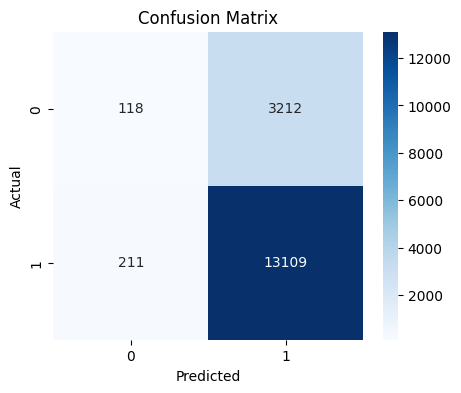

In [28]:
# Cell 6: evaluation
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Age                                  0.010239
Billing Amount                       0.008159
Hospital_Inc Williams                0.005256
Hospital_Ramirez Group               0.003820
Hospital_Owens PLC                   0.003281
Hospital_LLC Reed                    0.003185
Medical Condition_Obesity            0.003128
Doctor_Mary Smith                    0.002972
Hospital_Ltd King                    0.002901
Hospital_PLC Bell                    0.002795
Hospital_Gomez-Ellis                 0.002547
Hospital_Group Daugherty             0.002532
Doctor_Christopher Davis             0.002465
Hospital_Group Cannon                0.002447
Doctor_Scott Cox                     0.002342
Doctor_Robert Glover                 0.002187
Doctor_Austin Washington             0.002127
Doctor_Amanda Jones                  0.002113
Hospital_Lopez PLC                   0.002071
Doctor_Jessica Pratt                 0.002045
Test Results_Inconclusive            0.002016
Gender_Male                       

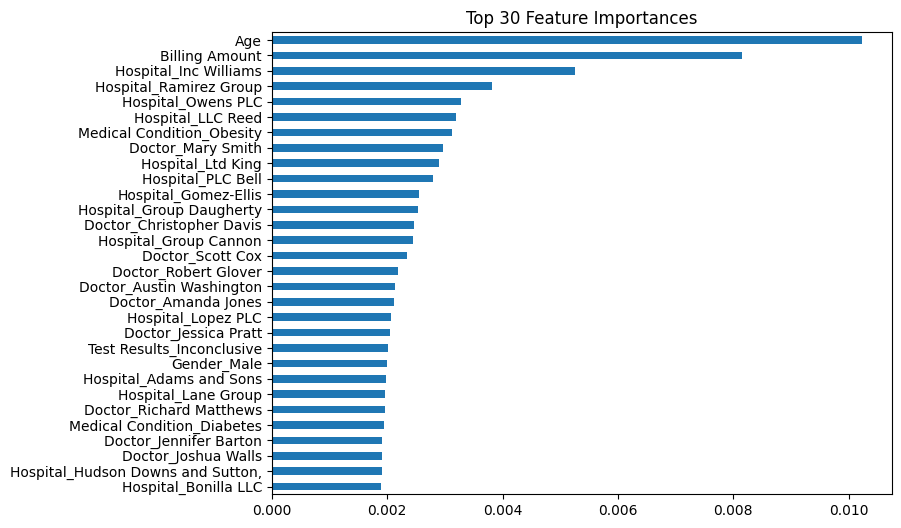

In [29]:
# Cell 7: feature importance (needs feature names after preprocessing)
# Extract feature names from preprocessor
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
ohe_feature_names = list(ohe.get_feature_names_out(categorical_features))
feature_names = numeric_features + ohe_feature_names

importances = clf.named_steps['classifier'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
display(feat_imp)

# Plot top features
plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top 30 Feature Importances')
plt.show()


In [30]:
import tarfile
import os

# Cell 8: save model

model_path = "/tmp/model_rf_prolonged_stay.joblib"
joblib.dump(clf, model_path)

print("Model saved to:", model_path)





Model saved to: /tmp/model_rf_prolonged_stay.joblib


In [78]:
import boto3
import json
import pandas as pd

runtime_client = boto3.client('sagemaker-runtime')
content_type = "application/json"
# input_data = X_test.iloc[1:2].values.tolist()
input_data = X_test.iloc[1:30].to_json()
#input_data = X_test.iloc[1:3].to_json(orient='records')
# print(X_test.iloc[1:3])
# print(input_data)
# request_body = {"Input": [[0.09178, 0.0, 4.05, 0.0, 0.51, 6.416, 84.1, 2.6463, 5.0, 296.0, 16.6, 395.5, 9.04]]}
request_body = {"Input": input_data}



data = json.loads(json.dumps(request_body))
payload = json.dumps(data)

new_df = pd.DataFrame(json.loads(json.loads(payload)['Input']))
#print(X_test.iloc[1:3])
#print(new_df.shape)
#print(new_df)


endpoint_name = "qyang-healthcare-ep23-19-04"

response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType=content_type,
    Body=payload)
result = json.loads(response['Body'].read().decode())['Output']
print(result)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
